## Introduction

In this tutorial, we will implement a type of graph neural network (GNN) known as
_ message passing neural network_ (MPNN) to predict graph properties. Specifically, we will
implement an MPNN to predict a molecular property known as
_blood-brain barrier permeability_ (BBBP).

Motivation: as molecules are naturally represented as an undirected graph `G = (V, E)`,
where `V` is a set or vertices (nodes; atoms) and `E` a set of edges (bonds), GNNs (such
as MPNN) are proving to be a useful method for predicting molecular properties.

Until now, more traditional methods, such as random forests, support vector machines, etc.,
have been commonly used to predict molecular properties. In contrast to GNNs, these
traditional approaches often operate on precomputed molecular features such as
molecular weight, polarity, charge, number of carbon atoms, etc. Although these
molecular features prove to be good predictors for various molecular properties, it is
hypothesized that operating on these more "raw", "low-level", features could prove even
better.

### References

In recent years, a lot of effort has been put into developing neural networks for
graph data, including molecular graphs. For a summary of graph neural networks, see e.g.,
[A Comprehensive Survey on Graph Neural Networks](https://arxiv.org/abs/1901.00596) and
[Graph Neural Networks: A Review of Methods and Applications](https://arxiv.org/abs/1812.08434);
and for further reading on the specific
graph neural network implemented in this tutorial see
[Neural Message Passing for Quantum Chemistry](https://arxiv.org/abs/1704.01212) and
[DeepChem's MPNNModel](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#mpnnmodel).

### Import packages

In [33]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

try:
    import rdkit
    from rdkit import Chem
    from rdkit.Chem import AllChem
    from rdkit import rdBase
    from rdkit.Chem.rdchem import HybridizationType
    from rdkit import RDConfig
    from rdkit.Chem import ChemicalFeatures
    from rdkit.Chem.rdchem import BondType as BT
    from rdkit.Chem import Draw
    rdBase.DisableLog('rdApp.error')
except ImportError:
    rdkit = None

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)

## Dataset

Information about the dataset can be found in
[A Bayesian Approach to in Silico Blood-Brain Barrier Penetration Modeling](https://pubs.acs.org/doi/10.1021/ci300124c)
and [MoleculeNet: A Benchmark for Molecular Machine Learning](https://arxiv.org/abs/1703.00564).
The dataset will be downloaded from [MoleculeNet.org](https://moleculenet.org/datasets-1).

### About

The dataset contains **2,050** molecules. Each molecule come with a **name**, **label**
and **SMILES** string.

The blood-brain barrier (BBB) is a membrane separating the blood from the brain
extracellular fluid, hence blocking out most drugs (molecules) from reaching
the brain. Because of this, the BBBP has been important to study for the development of
new drugs that aim to target the central nervous system. The labels for this
data set are binary (1 or 0) and indicate the permeability of the molecules.

In [34]:
dataset = pd.read_csv('../data/raw_data.csv',low_memory=False)
dataset = pd.concat([dataset['Smiles'], dataset['Tb']], axis=1)
dataset

,Smiles,Tb
0,CCC(O)CCC(F)(F)F,413.80
1,CCC(CC)ON(=O)=O,413.15
2,Clc1ccc(Cl)c(c1)C(=O)O,574.15
3,NC(C)Cc1ccccc1,476.15
4,COc1ccc(cc1)NC(=O)C,608.15
...,...,...
5271,BrC(F)(F)Oc1ccc(cc1)C(C)(C)COCc2cccc(Oc3ccccc3)c2,564.15
5272,OCC(C)CC(F)(F)F,405.65
5273,Clc1ccc(cc1)CC2CCC(C)(C)C2(O)CN3C=NC=N3,558.15
5274,CCOC(=O)C(Cl)Cc1cc(c(F)cc1Cl)N2N=C(C)N(C(F)F)C2=O,625.65


In [ ]:
# Standardize


### Define features

To encode features for atoms and bonds (which we will need later),
we'll define two classes: `AtomFeaturizer` and `BondFeaturizer` respectively.

To reduce the lines of code, i.e., to keep this tutorial short and concise,
only about a handful of (atom and bond) features will be considered: \[atom features\]
[symbol (element)](https://en.wikipedia.org/wiki/Chemical_element),
[number of valence electrons](https://en.wikipedia.org/wiki/Valence_electron),
[number of hydrogen bonds](https://en.wikipedia.org/wiki/Hydrogen),
[orbital hybridization](https://en.wikipedia.org/wiki/Orbital_hybridisation),
\[bond features\]
[(covalent) bond type](https://en.wikipedia.org/wiki/Covalent_bond), and
[conjugation](https://en.wikipedia.org/wiki/Conjugated_system).

In [35]:
# Done
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output

# Atom features class
class AtomFeature_encode(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def atom_list(self, atom):
        return atom.GetSymbol()

    def n_bonds(self, atom):
        return atom.GetImplicitValence()

    def numH_list(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()
    
    def aromatic(self,atom):
        return atom.GetIsAromatic()
    
    def ring(self,atom):
        return atom.IsInRing()
    
    def formal_charge(self,atom):
        return atom.GetFormalCharge()


class BondFeature_encode(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()
    
    def inring(self,bond):
        return bond.IsInRing()
    
    def stereo(self,bond):
        return str(bond.GetStereo()).upper()


atom_featurizer = AtomFeature_encode(
    allowable_sets={
        "atom_list": {'H','C', 'O', 'F','N','Cl','P','S','Si','Br','I'},
        "n_bonds": {0, 1, 2, 3, 4, 5},
        "numH_list": {0, 1, 2, 3, 4},
        "hybridization": {"sp", "sp2", "sp3","sp3d2"},
        "aromatic":{True, False},
        "ring":{True, False},
        "formal_charge": {-4,-3, -2, -1, 0, 1, 2, 3, 4},
    }
)

bond_featurizer = BondFeature_encode(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "inring": {True, False},
        "conjugated": {True, False},
        "stereo": {"STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"},
    }
)


### Generate graphs

Before we can generate complete graphs from SMILES, we need to implement the following functions:

1. `molecule_from_smiles`, which takes as input a SMILES and returns a molecule object.
This is all handled by RDKit.

2. `graph_from_molecule`, which takes as input a molecule object and returns a graph,
represented as a three-tuple (atom_features, bond_features, pair_indices). For this we
will make use of the classes defined previously.

Finally, we can now implement the function `graphs_from_smiles`, which applies function (1)
and subsequently (2) on all SMILES of the training, validation and test datasets.

Notice: although scaffold splitting is recommended for this data set (see
[here](https://arxiv.org/abs/1703.00564)), for simplicity, simple random splittings were
performed.

In [36]:

def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(dataset.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(dataset.shape[0] * 0.8)]
x_train = graphs_from_smiles(dataset.iloc[train_index].Smiles)
y_train = dataset.iloc[train_index].Tb

# Valid set: 10 % of data
valid_index = permuted_indices[int(dataset.shape[0] * 0.8) : int(dataset.shape[0] * 0.9)]
x_valid = graphs_from_smiles(dataset.iloc[valid_index].Smiles)
y_valid = dataset.iloc[valid_index].Tb

# Test set: 10 % of data
test_index = permuted_indices[int(dataset.shape[0] * 0.9) :]
x_test = graphs_from_smiles(dataset.iloc[test_index].Smiles)
y_test = dataset.iloc[test_index].Tb

### Test the functions

SMILES String:	FCF
Boiling Point:	221.55
Molecule:


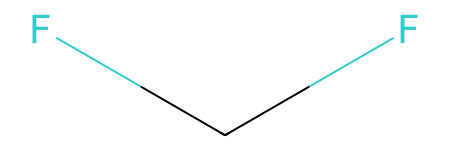

In [37]:
print(f"SMILES String:\t{dataset.Smiles[100]}\nBoiling Point:\t{dataset.Tb[100]}")
molecule = molecule_from_smiles(dataset.iloc[100].Smiles)
print("Molecule:")
molecule

In [38]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)


Graph (including self-loops):
	atom features	 (3, 39)
	bond features	 (7, 13)
	pair indices	 (7, 2)


### Create a `tf.data.Dataset`

In this tutorial, the MPNN implementation will take as input (per iteration) a single graph.
Therefore, given a batch of (sub)graphs (molecules), we need to merge them into a
single graph (we'll refer to this graph as *global graph*).
This global graph is a disconnected graph where each subgraph is
completely separated from the other subgraphs.

In [39]:

def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)


## Model

The MPNN model can take on various shapes and forms. In this tutorial, we will implement an
MPNN based on the original paper
[Neural Message Passing for Quantum Chemistry](https://arxiv.org/abs/1704.01212) and
[DeepChem's MPNNModel](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#mpnnmodel).
The MPNN of this tutorial consists of three stages: message passing, readout and
classification.


### Message passing

The message passing step itself consists of two parts:

1. The *edge network*, which passes messages from 1-hop neighbors `w_{i}` of `v`
to `v`, based on the edge features between them (`e_{vw_{i}}`),
resulting in an updated node (state) `v'`. `w_{i}` denotes the `i:th` neighbor of
`v`.

2. The *gated recurrent unit* (GRU), which takes as input the most recent node state
and updates it based on previous node states. In
other words, the most recent node state serves as the input to the GRU, while the previous
node states are incorporated within the memory state of the GRU. This allows information
to travel from one node state (e.g., `v`) to another (e.g., `v''`).

Importantly, step (1) and (2) are repeated for `k steps`, and where at each step `1...k`,
the radius (or number of hops) of aggregated information from `v` increases by 1.

In [40]:

class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated


### Readout

When the message passing procedure ends, the k-step-aggregated node states are to be partitioned
into subgraphs (correspoding to each molecule in the batch) and subsequently
reduced to graph-level embeddings. In the
[original paper](https://arxiv.org/abs/1704.01212), a
[set-to-set layer](https://arxiv.org/abs/1511.06391) was used for this purpose.
In this tutorial however, a transformer encoder + average pooling will be used. Specifically:

* the k-step-aggregated node states will be partitioned into the subgraphs
(corresponding to each molecule in the batch);
* each subgraph will then be padded to match the subgraph with the greatest number of nodes, followed
by a `tf.stack(...)`;
* the (stacked padded) tensor, encoding subgraphs (each subgraph containing a set of node states), are
masked to make sure the paddings don't interfere with training;
* finally, the tensor is passed to the transformer followed by average pooling.

In [41]:

class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)


### Message Passing Neural Network (MPNN)

It is now time to complete the MPNN model. In addition to the message passing
and readout, a two-layer classification network will be implemented to make
predictions of BBBP.

In [42]:

def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="linear")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None)],
)

### Training

In [43]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
)
'''
plt.figure(figsize=(10, 6))
plt.plot(history.history["AUC"], label="train AUC")
plt.plot(history.history["val_AUC"], label="valid AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)
'''

Epoch 1/40
132/132 - 19s - loss: 166503.3125 - root_mean_squared_error: 408.0482 - val_loss: 75682.2031 - val_root_mean_squared_error: 275.1040 - 19s/epoch - 142ms/step
Epoch 2/40
132/132 - 14s - loss: 26467.8555 - root_mean_squared_error: 162.6894 - val_loss: 7683.9395 - val_root_mean_squared_error: 87.6581 - 14s/epoch - 103ms/step
Epoch 3/40
132/132 - 13s - loss: 5913.3281 - root_mean_squared_error: 76.8982 - val_loss: 3258.7234 - val_root_mean_squared_error: 57.0852 - 13s/epoch - 101ms/step
Epoch 4/40
132/132 - 12s - loss: 3952.9751 - root_mean_squared_error: 62.8727 - val_loss: 2540.1289 - val_root_mean_squared_error: 50.3997 - 12s/epoch - 95ms/step
Epoch 5/40
132/132 - 13s - loss: 3406.0503 - root_mean_squared_error: 58.3614 - val_loss: 2403.4214 - val_root_mean_squared_error: 49.0247 - 13s/epoch - 96ms/step
Epoch 6/40
132/132 - 13s - loss: 3097.0266 - root_mean_squared_error: 55.6509 - val_loss: 2536.0459 - val_root_mean_squared_error: 50.3592 - 13s/epoch - 96ms/step
Epoch 7/40


KeyboardInterrupt: 

### Predicting

In [ ]:
molecules = [molecule_from_smiles(df.smiles.values[index]) for index in test_index]
y_true = [df.p_np.values[index] for index in test_index]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

## Conclusions

In this tutorial, we demonstarted a message passing neural network (MPNN) to
predict blood-brain barrier permeability (BBBP) for a number of different molecules. We
first had to construct graphs from SMILES, then build a Keras model that could
operate on these graphs, and finally train the model to make the predictions.

Example available on HuggingFace

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-mpnn%20molecular%20graphs-black.svg)](https://huggingface.co/keras-io/MPNN-for-molecular-property-prediction) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-mpnn%20molecular%20graphs-black.svg)](https://huggingface.co/spaces/keras-io/molecular-property-prediction) |